**1. Importación:**

El archivo **"resultados_estimacion.csv"**, contiene:

- **KO:** Estimatión por Kriging Ordinario
- **KO Average Sample Distance:** Distancia promedio del punto a estimar con relación a los datos.
- **KO KRIG VAR:** Varianza de Estimación de Kriging Ordinario
- **KO N Samples:** Número de datos en la vecindad de Kriging
- **Calidad Code:** Calidad de la muestra (depende del muestreo)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

df = pd.read_csv("resultados_estimacion.csv", sep=";")
grid_x = np.linspace(10,1010, num=50, endpoint=False) #Número de celdas en X
grid_y = np.linspace(10,1010, num=50, endpoint=False) #Número de celdas en Y
gy = np.array(grid_y)
gx = np.array(grid_x) 
yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') 
x_g = xg.ravel() 
y_g = yg.ravel() 
d = {'X': x_g, 'Y': y_g} 
df1 = pd.DataFrame(data=d)   
df["X"] = df1["X"]
df["Y"] = df1["Y"]
df.replace(-99, np.nan, inplace=True)
df= df.dropna()
df['calidad_code'] = df['ko krig_var'].apply(lambda x: 0 if x < 0.08 else 1)
df["cov"] = (np.sqrt(df["ko krig_var"])/df["ko"])
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples,X,Y,calidad_code,cov
133,1.19737,119.423,0.309090,6.0,670.0,50.0,1,0.464316
134,1.19485,119.771,0.313933,5.0,690.0,50.0,1,0.468927
182,1.10442,99.171,0.283412,5.0,650.0,70.0,1,0.482031
183,1.15411,110.082,0.295798,5.0,670.0,70.0,1,0.471249
184,1.14318,112.859,0.278678,5.0,690.0,70.0,1,0.461782


In [4]:
def actualizar_calidad(df):
    df_actualizado = df.copy()
    for index, row in df.iterrows():
        x, y, calidad = row['X'], row['Y'], row['calidad_code']
        h=20 #indicar tamaño de bloques
        indices_circundantes = ((df['X'] == x - h) & (df['Y'] == y)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y)) | \
                               ((df['X'] == x + h) & (df['Y'] == y)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y)) | \
                               ((df['X'] == x) & (df['Y'] == y - h)) | \
                               ((df['X'] == x) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x) & (df['Y'] == y + h)) | \
                               ((df['X'] == x) & (df['Y'] == y + 2*h)) | \
                               ((df['X'] == x - h) & (df['Y'] == y - h)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y - h)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x - h) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x - h) & (df['Y'] == y + h)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y + h)) | \
                               ((df['X'] == x - h) & (df['Y'] == y + 2*h)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y + 2*h)) | \
                               ((df['X'] == x + h) & (df['Y'] == y - h)) | \
                               ((df['X'] == x + h) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y - h)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x + h) & (df['Y'] == y + h)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y + h)) | \
                               ((df['X'] == x + h) & (df['Y'] == y + 2*h)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y + 2*h))
        porcentaje_otras_categorias = np.mean(df.loc[indices_circundantes, 'calidad_code'] != calidad)
        if porcentaje_otras_categorias > 0.51:
            categorias_circundantes = df.loc[indices_circundantes, 'calidad_code']
            nueva_categoria = categorias_circundantes.mode().iloc[0]
            df_actualizado.at[index, 'calidad_code'] = nueva_categoria
    return df_actualizado

df_calidad = actualizar_calidad(df)
df_calidad2 = actualizar_calidad(df_calidad)
df_calidad3 = actualizar_calidad(df_calidad2)
df["confianza"] = df_calidad3["calidad_code"]

df['confianza_geo'] = df['confianza'].map({0: 'baja', 1: 'alta'})
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples,X,Y,calidad_code,cov,confianza,confianza_geo
133,1.19737,119.423,0.309090,6.0,670.0,50.0,1,0.464316,1,alta
134,1.19485,119.771,0.313933,5.0,690.0,50.0,1,0.468927,1,alta
182,1.10442,99.171,0.283412,5.0,650.0,70.0,1,0.482031,1,alta
183,1.15411,110.082,0.295798,5.0,670.0,70.0,1,0.471249,1,alta
184,1.14318,112.859,0.278678,5.0,690.0,70.0,1,0.461782,1,alta


In [6]:
from sklearn.preprocessing import PowerTransformer

variables_deseadas = ["ko average sample distance", "ko krig_var", "ko n samples"]
nuevo_df1 = df[variables_deseadas].copy()
pt = PowerTransformer()
X_transformed = pt.fit_transform(nuevo_df1)
nuevo_df = pd.DataFrame(X_transformed, columns=variables_deseadas)
nuevo_df["calidad"] = df["confianza_geo"].values
nuevo_df.head()

,ko average sample distance,ko krig_var,ko n samples,calidad
0,1.467530,2.219870,-1.195824,alta
1,1.484746,2.255433,-1.604855,alta
2,0.396621,2.019533,-1.604855,alta
3,0.991292,2.118714,-1.604855,alta
4,1.135819,1.980311,-1.604855,alta


**2. Agrupamiento:**

In [7]:
kproto = KPrototypes(n_clusters=3, init='Huang', n_jobs = 4, random_state=17276365)
clusters_kproto = kproto.fit_predict(nuevo_df, categorical=[3])

In [8]:
df["Categoria"] = clusters_kproto
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples,X,Y,calidad_code,cov,confianza,confianza_geo,Categoria
133,1.19737,119.423,0.309090,6.0,670.0,50.0,1,0.464316,1,alta,1
134,1.19485,119.771,0.313933,5.0,690.0,50.0,1,0.468927,1,alta,1
182,1.10442,99.171,0.283412,5.0,650.0,70.0,1,0.482031,1,alta,1
183,1.15411,110.082,0.295798,5.0,670.0,70.0,1,0.471249,1,alta,1
184,1.14318,112.859,0.278678,5.0,690.0,70.0,1,0.461782,1,alta,1


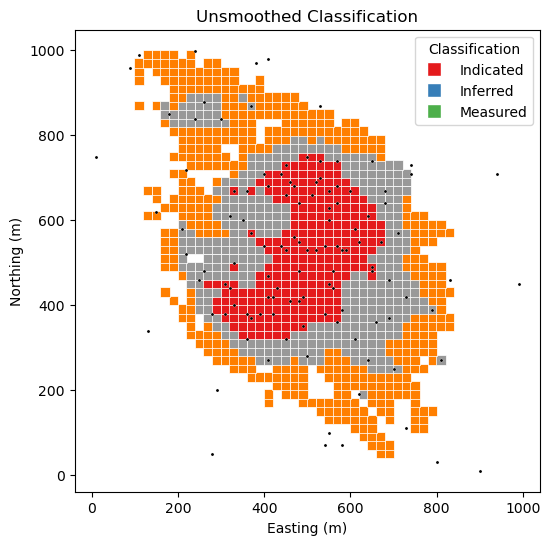

In [11]:
import seaborn as sns

df_sample = pd.read_excel("samples_2d.xlsx")

plt.figure(figsize=(6, 6))
marker_size = 45
marker_size2 = 5
palette1 = sns.color_palette("Set1", as_cmap=True)
scatterplot1 = sns.scatterplot(x=df["X"], y=df["Y"], hue=df["Categoria"], palette=palette1, s=marker_size, marker="s")
scatterplot2 = sns.scatterplot(x=df_sample["X"], y=df_sample["Y"], color="black", s=marker_size2, marker="o")
labels_dict = {0: "Measured", 1: "Indicated", 2: "Inferred"}
labels = [labels_dict[val] for val in df["Categoria"].unique()]
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', label=label, markersize=10, markerfacecolor=palette1(i)) for i, label in enumerate(labels)]
scatterplot1.legend(handles=legend_elements, title="Classification", labels=labels)
plt.title("Unsmoothed Classification")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

**3. Suavizado:**

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


X = df[['X', 'Y']]
y = df['Categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = Sequential()
model.add(Dense(128, input_dim=2, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 neuronas de salida para las tres categorías
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
predictions = model.predict(X_test)
predicted_categories = np.argmax(predictions, axis=1)
X_original = df[['X', 'Y']]
X_original = scaler.transform(X_original)
predictions_original = model.predict(X_original)
predicted_categories_original = np.argmax(predictions_original, axis=1)
df['Categoria_s_original'] = predicted_categories_original

Epoch 1/200
26/26 [==============================] - 2s 27ms/step - loss: 0.9858 - accuracy: 0.3927 - val_loss: 0.9173 - val_accuracy: 0.4488
Epoch 2/200
26/26 [==============================] - 0s 7ms/step - loss: 0.9089 - accuracy: 0.4732 - val_loss: 0.8644 - val_accuracy: 0.5463
Epoch 3/200
26/26 [==============================] - 0s 7ms/step - loss: 0.8574 - accuracy: 0.5902 - val_loss: 0.8082 - val_accuracy: 0.6585
Epoch 4/200
26/26 [==============================] - 0s 8ms/step - loss: 0.8094 - accuracy: 0.6354 - val_loss: 0.7442 - val_accuracy: 0.7366
Epoch 5/200
26/26 [==============================] - 0s 7ms/step - loss: 0.7513 - accuracy: 0.6854 - val_loss: 0.6753 - val_accuracy: 0.7707
Epoch 6/200
26/26 [==============================] - 0s 7ms/step - loss: 0.6874 - accuracy: 0.7146 - val_loss: 0.6011 - val_accuracy: 0.8195
Epoch 7/200
26/26 [==============================] - 0s 8ms/step - loss: 0.6170 - accuracy: 0.7720 - val_loss: 0.5274 - val_accuracy: 0.8488
Epoch 8/200


Epoch 59/200
26/26 [==============================] - 0s 7ms/step - loss: 0.3285 - accuracy: 0.8622 - val_loss: 0.2697 - val_accuracy: 0.8732
Epoch 60/200
26/26 [==============================] - 0s 7ms/step - loss: 0.3266 - accuracy: 0.8561 - val_loss: 0.2766 - val_accuracy: 0.8780
Epoch 61/200
26/26 [==============================] - 0s 7ms/step - loss: 0.3177 - accuracy: 0.8671 - val_loss: 0.2725 - val_accuracy: 0.9171
Epoch 62/200
26/26 [==============================] - 0s 7ms/step - loss: 0.3220 - accuracy: 0.8707 - val_loss: 0.2683 - val_accuracy: 0.8878
Epoch 63/200
26/26 [==============================] - 0s 7ms/step - loss: 0.3187 - accuracy: 0.8768 - val_loss: 0.2643 - val_accuracy: 0.9122
Epoch 64/200
26/26 [==============================] - 0s 7ms/step - loss: 0.3154 - accuracy: 0.8695 - val_loss: 0.2590 - val_accuracy: 0.9024
Epoch 65/200
26/26 [==============================] - 0s 7ms/step - loss: 0.3123 - accuracy: 0.8780 - val_loss: 0.2629 - val_accuracy: 0.9073
Epoch 

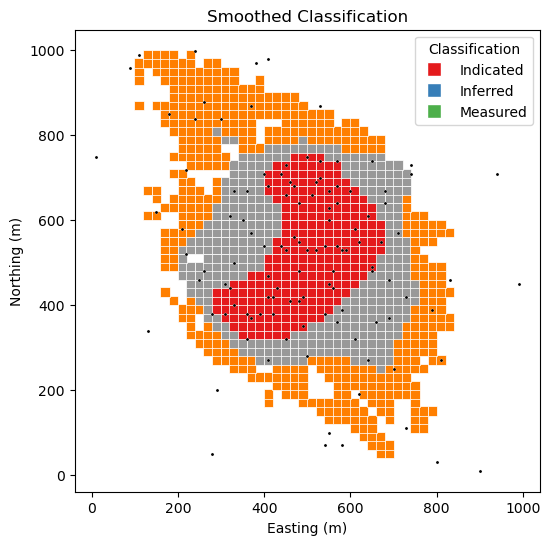

In [17]:
plt.figure(figsize=(6, 6))
marker_size = 45
marker_size2 = 5
palette1 = sns.color_palette("Set1", as_cmap=True)
scatterplot1 = sns.scatterplot(x=df["X"], y=df["Y"], hue=df["Categoria_s_original"], palette=palette1, s=marker_size, marker="s")
scatterplot2 = sns.scatterplot(x=df_sample["X"], y=df_sample["Y"], color="black", s=marker_size2, marker="o")
labels_dict = {0: "Measured", 1: "Indicated", 2: "Inferred"}
labels = [labels_dict[val] for val in df["Categoria_s_original"].unique()]
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', label=label, markersize=10, markerfacecolor=palette1(i)) for i, label in enumerate(labels)]
scatterplot1.legend(handles=legend_elements, title="Classification", labels=labels)
plt.title("Smoothed Classification")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

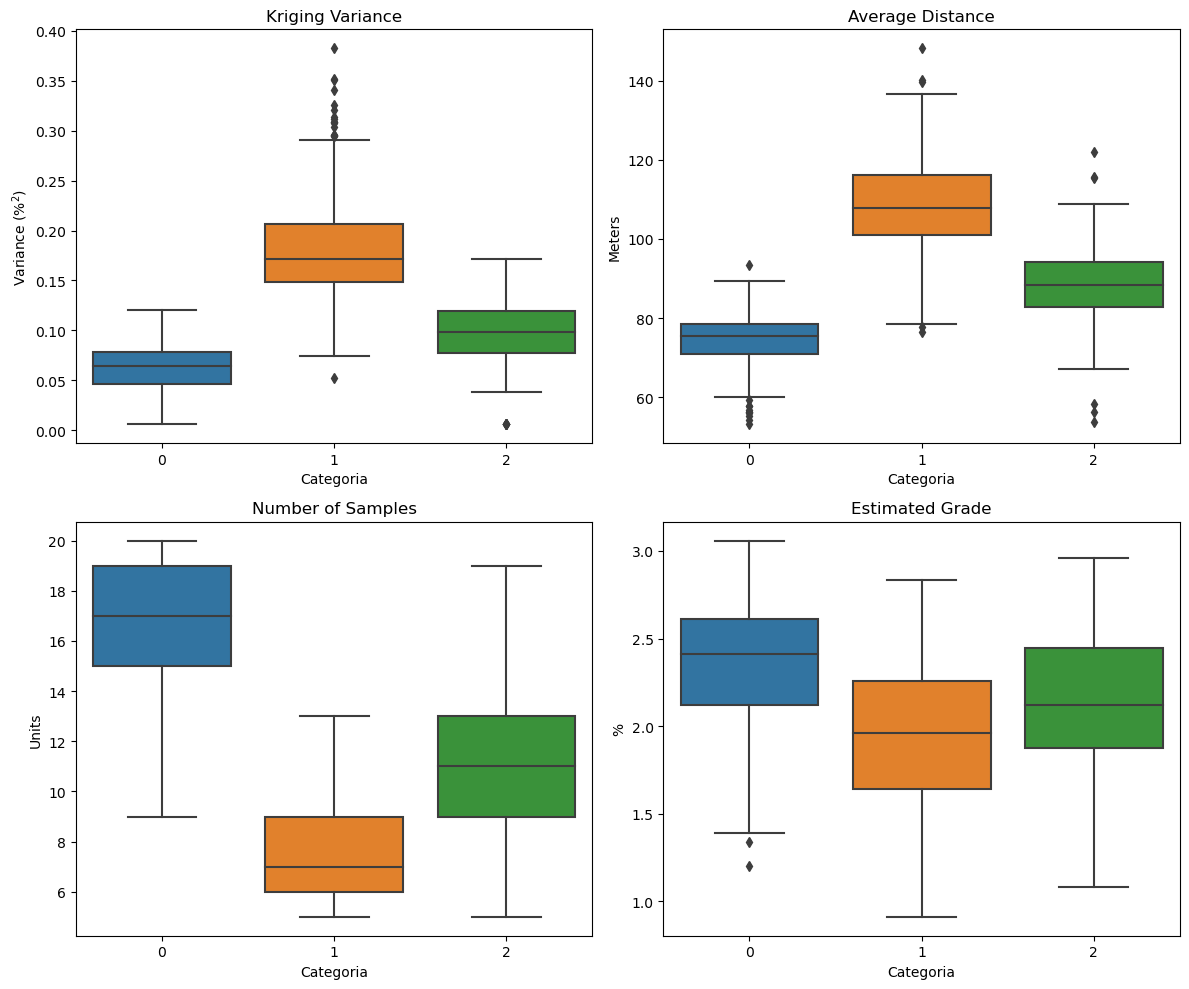

In [18]:
columnas_interes = ['ko krig_var', 'ko average sample distance', 'ko n samples', 'ko']
df_seleccionado = df[columnas_interes]
nombre_eje_x = 'Categoria'
nombres_etiquetas = ['Kriging Variance', 'Average Distance', 'Number of Samples', 'Estimated Grade']
nombres_eje_y = ['Variance (%$^2$)', 'Meters', 'Units', '%']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, columna in enumerate(df_seleccionado.columns):
    sns.boxplot(x=nombre_eje_x, y=columna, data=df, ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(nombres_etiquetas[i])
    axs[i // 2, i % 2].set_xlabel(nombre_eje_x)
    axs[i // 2, i % 2].set_ylabel(nombres_eje_y[i])
plt.tight_layout()
plt.show()